# NHL Player Salary Analysis, data credit from http://www.hockeyabstract.com/testimonials/nhl2017-18. Thank you very much to the work of all those involved at Hockey Abstract for their work and sharing of this feature rich dataset. 

In [1]:
import pandas as pd
import numpy as np
from math import pi
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib notebook

### A cursory exploration of the Excel file containing our data shows several sheets, each with many columns that describe different statistics compiled of each player. All credit for compiling these statistics goes to those working at Hockey Abstract, check out their site!

### This Excel file can be quite intimidating if you have no background in Hockey, or the type of stats that can be collected. Luckily we have sheets containing abbreviation meanings, section backgrounds, and the source of a given column. Sadly, there is no easy and quick way for Pandas to interpret an Excel Pivot table. This makes our first task importing the data into a form we can easily interpret and manage for the duration of this project. We import separate dataframes for the various abbreviation and legend Sheets.

In [2]:
abbrev_df = pd.read_excel('NHL 2017-18/NHL 2017-18.xls',sheet_name='Legend',skiprows=34)

In [3]:
abbrev_df.head(5)

,Abbreviation or Acronym,Meaning
0,+/-,Plus/minus
1,1G,First goals of a game
2,A1,"First assists, primary assists"
3,BLK%,Percentage of all opposing shot attempts block...
4,Born,Birth date


### This allows a quick way to look up the meaning of different columns.

In [4]:
abbrev_df.loc[abbrev_df['Abbreviation or Acronym']=='Ovrl']

,Abbreviation or Acronym,Meaning
152,Ovrl,Where the player was drafted overall


### The different sections we have access too are contained in the dataframe below.

In [5]:
sec_df = pd.read_excel('NHL 2017-18/NHL 2017-18.xls',sheet_name='Legend',skiprows=11,nrows = 21)

In [6]:
sec_df.head(5)

,Section,Meaning
0,Career Stats,Some basic totals for the player's entire care...
1,Catch-All,"All-in-one stats, like GVT, Point Shares, and WAR"
2,Contract Information,"Contractual information, like cap hit and no-m..."
3,Equipment,The equipment the player uses
4,Faceoff Stats,Stats about faceoffs


### The Hockey Abstract site uses many different sources for their stats, we can look at the second row of the Excel sheet to infer which column comes from which source. We must be careful to map over the correct category, done in the cells below. This will serve as a guide to what column number is in which category, from which source. It is zero indexed for ease of manipulation.

In [7]:
source_df = pd.read_excel('NHL 2017-18/NHL 2017-18.xls',sheet_name='TOT',nrows=1).melt(var_name='Stat Category',value_name='Source')

In [8]:
source_df.head(21)

,Stat Category,Source
0,Player Information,NHL
1,Unnamed: 1,NHL
2,Unnamed: 2,NHL
3,Unnamed: 3,NHL
4,Unnamed: 4,NHL
5,Unnamed: 5,NHL
6,Unnamed: 6,NHL
7,Unnamed: 7,NHL
8,Unnamed: 8,NHL
9,Unnamed: 9,NHL


In [9]:
#Find the index values that seperate our category names
hold = source_df.index[source_df['Stat Category'].str.startswith('Un') == False]

#Map over the correct category for the source.
list_range = []
for item in range(len(hold)-1):
    list_range.append(np.arange(hold[item],hold[item+1]))

list_range.append(np.arange(hold[-1],len(source_df['Stat Category'])))


for item in list_range:
    source_df.loc[item,'Stat Category'] = source_df['Stat Category'].loc[item[0]] 

In [10]:
source_df.head(5)

,Stat Category,Source
0,Player Information,NHL
1,Player Information,NHL
2,Player Information,NHL
3,Player Information,NHL
4,Player Information,NHL


### Due to all of the different categories available it does not make much sense to import the Excel file into a single dataframe in its current form. It would be nice if first we could import the data by category, but this introduces problems of knowing which category each column belongs too. Moving forward we create new column names including abbreviations of their designated category, with the goal of creating a dataframe for each unique category.

In [11]:
#Create a list of dataframe variable names we will use in the future
cat_df_list = [item.replace(' ','_').replace('-','_')+'_df' for item in source_df['Stat Category'].unique().tolist()]
cat_df_list

['Player_Information_df',
 'Primary_Stats_df',
 'Individual_Stats_df',
 'Faceoff_Stats_df',
 'Individual_Goal_and_Shot_Breakdown_df',
 'Penalty_Stats_df',
 'On_Ice_Team_Stats_df',
 'Catch_All_df',
 'Other_df',
 'Contract_Information_df',
 'Equipment_df',
 'Career_Stats_df']

In [12]:
#We would like to automate as much as possible, but creating our own abbreviations is necessary here
cat_abbrv_list = ['PlInf','PrimStat','IndStat','FaceStat','IndGoalStat','PenStat','OITStat','CatAll','Other',
                  'ContInf','Eqip','CarStat']

In [13]:
#First we will go through a single category, then later create a dictionary containing key value pairs for each
#category dataframe
df = pd.read_excel('NHL 2017-18/NHL 2017-18.xls',sheet_name='TOT',usecols=list_range[1],skiprows=2)

In [14]:
df.head()

,GP,G,A,A1,PTS,Rnk,Gap,PTS/GP,PAX,GC,...,E+/-,PIM,Shifts,TOI,TOI.1,TOI.2,TOI.3,TOI/GP,TOI%,IPP%
0,33,3,6,3,9,22,84,0.272727,-1.963455,3.394,...,-1.5,6,491,23617,393.616667,393.33,394,11.927778,20.18,0.473684
1,62,3,5,1,8,19,94,0.129032,-20.440367,2.908,...,-3.2,14,952,39114,651.900000,651.90,652,10.514516,17.88,0.470588
2,82,3,7,5,10,17,74,0.121951,-14.384840,3.527,...,0.4,28,1759,82396,1373.266667,1373.23,1373,16.747154,28.08,0.243902
3,62,13,11,8,24,14,40,0.387097,-11.674810,9.870,...,-3.7,82,1099,44707,745.116667,745.13,745,12.018011,20.52,0.705882
4,80,4,19,8,23,12,46,0.287500,0.684675,7.790,...,-5.1,20,2215,104951,1749.183333,1749.18,1749,21.864792,36.52,0.298701


In [15]:
#Add our abreviation and remove spaces from column names
cat_col_name = [cat_abbrv_list[1]+'_'+df.columns.tolist()[num].replace(' ','_') for num in range(len(df.columns.tolist()))]
cat_col_name[:5]

['PrimStat_GP', 'PrimStat_G', 'PrimStat_A', 'PrimStat_A1', 'PrimStat_PTS']

In [16]:
#Create a mapping dictionary so we can rename the columns, including the desired abbreviations
cat_dict_name = {df.columns.tolist()[num]:cat_col_name[num] for num in range(len(df.columns.tolist()))}
cat_dict_name

{'GP': 'PrimStat_GP',
 'G': 'PrimStat_G',
 'A': 'PrimStat_A',
 'A1': 'PrimStat_A1',
 'PTS': 'PrimStat_PTS',
 'Rnk': 'PrimStat_Rnk',
 'Gap': 'PrimStat_Gap',
 'PTS/GP': 'PrimStat_PTS/GP',
 'PAX': 'PrimStat_PAX',
 'GC': 'PrimStat_GC',
 '+/-': 'PrimStat_+/-',
 'E+/-': 'PrimStat_E+/-',
 'PIM': 'PrimStat_PIM',
 'Shifts': 'PrimStat_Shifts',
 'TOI': 'PrimStat_TOI',
 'TOI.1': 'PrimStat_TOI.1',
 'TOI.2': 'PrimStat_TOI.2',
 'TOI.3': 'PrimStat_TOI.3',
 'TOI/GP': 'PrimStat_TOI/GP',
 'TOI%': 'PrimStat_TOI%',
 'IPP%': 'PrimStat_IPP%'}

In [17]:
#Apply it to the dataframe
df = df.rename(columns=cat_dict_name)
df.head()

,PrimStat_GP,PrimStat_G,PrimStat_A,PrimStat_A1,PrimStat_PTS,PrimStat_Rnk,PrimStat_Gap,PrimStat_PTS/GP,PrimStat_PAX,PrimStat_GC,...,PrimStat_E+/-,PrimStat_PIM,PrimStat_Shifts,PrimStat_TOI,PrimStat_TOI.1,PrimStat_TOI.2,PrimStat_TOI.3,PrimStat_TOI/GP,PrimStat_TOI%,PrimStat_IPP%
0,33,3,6,3,9,22,84,0.272727,-1.963455,3.394,...,-1.5,6,491,23617,393.616667,393.33,394,11.927778,20.18,0.473684
1,62,3,5,1,8,19,94,0.129032,-20.440367,2.908,...,-3.2,14,952,39114,651.900000,651.90,652,10.514516,17.88,0.470588
2,82,3,7,5,10,17,74,0.121951,-14.384840,3.527,...,0.4,28,1759,82396,1373.266667,1373.23,1373,16.747154,28.08,0.243902
3,62,13,11,8,24,14,40,0.387097,-11.674810,9.870,...,-3.7,82,1099,44707,745.116667,745.13,745,12.018011,20.52,0.705882
4,80,4,19,8,23,12,46,0.287500,0.684675,7.790,...,-5.1,20,2215,104951,1749.183333,1749.18,1749,21.864792,36.52,0.298701


### We will automate the column abbreviation process above for each category, and then add that categories dataframe to a dictionary with an appropriate key.

In [18]:
# col_names = pd.read_excel('NHL 2017-18/NHL 2017-18.xls',sheet_name='TOT',nrows=1,skiprows=1).melt()['value']

In [19]:
dict_df = {}

for num_1 in range(len(cat_df_list)):
    hold_df = pd.read_excel('NHL 2017-18/NHL 2017-18.xls',sheet_name='TOT',usecols=list_range[num_1],skiprows=2)
#     hold_df.columns = col_names[list_range[num_1]].tolist()
#     print(hold_df)
    hold_col_name = [cat_abbrv_list[num_1]+'_'+hold_df.columns.tolist()[num_2].replace(' ','_') 
                    for num_2 in range(len(hold_df.columns.tolist()))]
    
    hold_dict_name = {hold_df.columns.tolist()[num_3]:hold_col_name[num_3] for num_3 in range(len(hold_df.columns.tolist()))}
    
    hold_df = hold_df.rename(columns=hold_dict_name)
    
    dict_df[cat_df_list[num_1]] = hold_df
    
    
    
    

In [20]:
dict_df['Career_Stats_df'].head()

,CarStat_GP.1,CarStat_G.1,CarStat_A.1,CarStat_PTS.1,CarStat_+/-.1,CarStat_PIM.1,CarStat_Shot,CarStat_TOI.4,CarStat_OPS.1,CarStat_DPS.1,CarStat_PS.1
0,334,54,55,109,-29,149,530,4120,6.9,3.2,10.1
1,280,33,75,108,19,134,298,4109,4.2,5.5,9.7
2,425,29,83,112,-46,238,652,8141,5.5,14.8,20.4
3,1249,327,380,707,66,1809,2777,19535,57.8,23.6,81.4
4,987,53,223,276,-61,410,1292,20909,10.5,41.0,51.5


### We make this choice so as to have easy lookup for each section of the Excel pivot table that we have now flattened. In the future we will concatenate all data into a single dataframe object.

In [21]:
dict_df['Player_Information_df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 21 columns):
PlInf_Born          890 non-null datetime64[ns]
PlInf_City          890 non-null object
PlInf_Pr/St         654 non-null object
PlInf_Cntry         890 non-null object
PlInf_Nat           890 non-null object
PlInf_Ht            890 non-null int64
PlInf_Wt            890 non-null int64
PlInf_DftYr         762 non-null float64
PlInf_DftRd         762 non-null float64
PlInf_Ovrl          762 non-null float64
PlInf_Hand          890 non-null object
PlInf_Debut         890 non-null int64
PlInf_Age           890 non-null int64
PlInf_Seasons       890 non-null int64
PlInf_NHLid         890 non-null int64
PlInf_CorsicaID     890 non-null object
PlInf_H-Ref_Name    890 non-null object
PlInf_Last_Name     890 non-null object
PlInf_First_Name    890 non-null object
PlInf_Position      890 non-null object
PlInf_Team          890 non-null object
dtypes: datetime64[ns](1), float64(3), int64(6), o

### We have 890 players, but curiously it appears we are missing draft information for 128 of them.

### How are the positions split between the players? Note we have a small number of players who play more than one position.

In [22]:
dict_df['Player_Information_df']['PlInf_Position'].value_counts()

D        306
C        236
LW       172
RW       137
LW/C      27
RW/C      10
LW/RW      1
C/RW       1
Name: PlInf_Position, dtype: int64

### How many players are on each team? Here we have used a lambda function to account for players listed in the spreadsheet playing for multiple teams. This way we only account for one team for a single player.

In [23]:
dict_df['Player_Information_df']['PlInf_Team'].apply(lambda x: x.split(',')[0]).value_counts()

OTT    36
ANA    34
BUF    33
BOS    32
MIN    32
MTL    32
CHI    31
NYR    30
VAN    30
STL    29
TOR    29
ARI    29
CGY    29
CAR    29
LAK    29
NYI    28
COL    28
CBJ    28
PIT    27
WSH    27
FLA    27
VGK    27
PHI    27
NJD    27
EDM    27
DET    26
WPG    26
TBL    26
SJS    25
DAL    25
NSH    25
Name: PlInf_Team, dtype: int64

### What is the player count per country?

In [24]:
dict_df['Player_Information_df']['PlInf_Cntry'].value_counts()

CAN    406
USA    248
SWE     86
RUS     33
CZE     31
FIN     31
CHE     13
SVK     10
DEU      6
DNK      6
AUT      5
FRA      4
GBR      2
NOR      2
EST      1
ITA      1
NLD      1
KAZ      1
ROU      1
LVA      1
SVN      1
Name: PlInf_Cntry, dtype: int64

### This projects main goal is to predict a player's salary, so to that end lets visualize the distribution of salary for all players in a histogram.

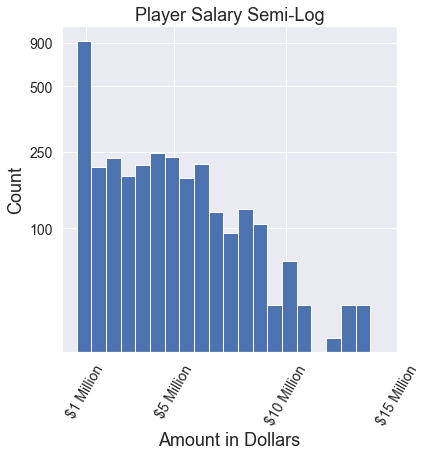

In [98]:
plt.figure(figsize=(6,6))
plt.hist(dict_df['Contract_Information_df'].ContInf_Salary,bins=20)
plt.yscale('log')
plt.title('Player Salary Semi-Log',size=18)
plt.xlabel('Amount in Dollars',size=18)
plt.ylabel('Count',size=18)
plt.yticks([10,50,200,500],['100','250','500','900'],size=14)
plt.xticks([1000000,5000000,10000000,15000000],['$1 Million','$5 Million','$10 Million','$15 Million'],rotation=60,size=14)
plt.show()

### One tool that is often underutilized is the radar/polar graph used to make comparisons. Often people choose bar plots to compare between multiple categories, but here we wish to use the radar plot. This will help make visual comparisons between all of the category rich data. Let us create some of these visualizations for our player information dataframe.

### We first look at visualizing the different positions. Those familiar with Hockey will notice from our above commands we are missing a position, the goalie. Going back to our source we found they did not include statistics on the NHL goalies for their own reasons. So here we only see the Center, Left and Right Wing, and Defense.

In [25]:
xx = dict_df['Player_Information_df']['PlInf_Position'].value_counts().index.tolist()
xx[:4]
yy = dict_df['Player_Information_df']['PlInf_Position'].value_counts().tolist()
yy[:4]

[306, 236, 172, 137]

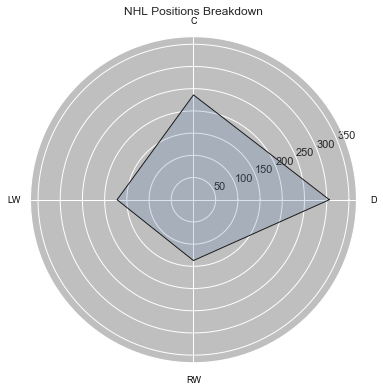

In [26]:
#Create the list for what goes on each radial axis
categories=dict_df['Player_Information_df']['PlInf_Position'].value_counts().index.tolist()[:4]

#Find length of list to use in plot
N = len(categories)

#Take the values we wish to plot. For the radar plot we repeat the last value
values = dict_df['Player_Information_df']['PlInf_Position'].value_counts().tolist()[:4]
values += values[:1]

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the radar plot
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.patch.set_facecolor('grey')
ax.patch.set_alpha(.50) 

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='black', size=9)

#Add title
plt.title('NHL Positions Breakdown')

# Draw ylabels
#ax.set_rlabel_position(45)
#plt.yticks([100,200,300], ['100','200','300'], color="black", size=8)
plt.ylim(0,max(values)+.2*max(values))
 
# Plot data
ax.plot(angles, values,'k', linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.2)

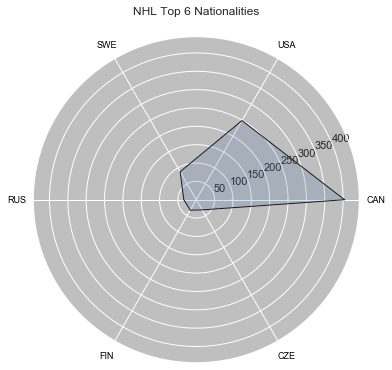

In [27]:
#Create the list for what goes on each radial axis
categories=dict_df['Player_Information_df']['PlInf_Nat'].value_counts().index.tolist()[:6]

#Find length of list to use in plot
N = len(categories)

#Take the values we wish to plot. For the radar plot we repeat the last value
values = dict_df['Player_Information_df']['PlInf_Nat'].value_counts().tolist()[:6]
values += values[:1]

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the radar plot
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.patch.set_facecolor('grey')
ax.patch.set_alpha(.50) 

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='black', size=9)

#Add title
plt.title('NHL Top 6 Nationalities')

# Draw ylabels
#ax.set_rlabel_position(90)
#plt.yticks([100,200,300], ['100','200','300'], color="black", size=8)
plt.ylim(0,max(values)+.1*max(values))
 
# Plot data
ax.plot(angles, values,'k', linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.2)

In [28]:
dict_df['Player_Information_df']

,PlInf_Born,PlInf_City,PlInf_Pr/St,PlInf_Cntry,PlInf_Nat,PlInf_Ht,PlInf_Wt,PlInf_DftYr,PlInf_DftRd,PlInf_Ovrl,...,PlInf_Debut,PlInf_Age,PlInf_Seasons,PlInf_NHLid,PlInf_CorsicaID,PlInf_H-Ref_Name,PlInf_Last_Name,PlInf_First_Name,PlInf_Position,PlInf_Team
0,1989-11-21,Dorchester,MA,USA,USA,77,215,2008.0,2.0,60.0,...,2011,28,7,8474625,JIMMY.HAYES,Jimmy Hayes,Hayes,Jimmy,RW,NJD
1,1987-12-23,Helsinki,NaN,FIN,FIN,74,212,2008.0,3.0,65.0,...,2014,30,4,8474627,JORI.LEHTERA,Jori Lehtera,Lehtera,Jori,C,PHI
2,1990-06-07,Winnipeg,MB,CAN,CAN,75,210,2008.0,3.0,69.0,...,2011,27,7,8474628,MICHAEL.STONE,Michael Stone,Stone,Michael,D,CGY
3,1982-04-18,Regina,SK,CAN,CAN,74,215,2000.0,1.0,6.0,...,2000,35,17,8468486,SCOTT.HARTNELL,Scott Hartnell,Hartnell,Scott,LW,NSH
4,1981-03-24,Bolton,CT,USA,USA,75,205,2000.0,1.0,13.0,...,2002,36,15,8468493,RON.HAINSEY,Ron Hainsey,Hainsey,Ron,D,TOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,1989-11-01,Paris,ON,CAN,CAN,74,194,2008.0,2.0,45.0,...,2010,28,8,8474610,ZAC.DALPE,Zac Dalpe,Dalpe,Zac,C,CBJ
886,1990-08-16,St. Malo,MB,CAN,CAN,74,205,2008.0,2.0,53.0,...,2010,27,8,8474612,TRAVIS.HAMONIC,Travis Hamonic,Hamonic,Travis,D,CGY
887,1990-06-18,Hastings,MN,USA,USA,72,196,2008.0,2.0,51.0,...,2010,27,8,8474613,DEREK.STEPAN,Derek Stepan,Stepan,Derek,C,ARI
888,1996-02-04,STILLWATER,MN,USA,USA,71,181,NaN,NaN,NaN,...,2017,21,1,8480761,MITCH.REINKE,Mitch Reinke,Reinke,Mitch,D,STL


### The amount of statistics on each player is a bit overwhelming. As a broad overview we wish to formulate some questions and explore the data in a first look basis. For EDA we will first handpick columns to explore, using basics of our hockey knowledge. The end goal is predicting player salary.

### How is it affected by physical measurements such as height and weight?

### Does handedness affect the average salary a player makes? Age?

### We would assume results like goals will be a major factor, but +/- stat(points made minus goals allowed while they played)? Shots on goal (iSF)?

### How do these correlate with time a player spends on the ice?

### Are there similar trends between the current year and career stats, i.e. Goals, assists, penalties in minutes (PIM, iPenT)?

### How about hustling and drawing penalties (forcing the other team to foul) (iPenD)?

### This type of EDA will depend on our radar plots we introduced above to make player vs player comparisons, as well as scatter plots of various styles to visualize trends between 2 features, and in some cases 3 variables where we will visualize the salary by the size of the marker. We will also utilize bar charts on single columns (height, weight, age, seasons played).

### After EDA and before modeling we will still need to address the missing values, and use our EDA for feature exploration and use in a regression type model to forecast salaries.

In [29]:
df_list = [v for k,v in dict_df.items()]
nhl = pd.concat(df_list,axis=1)

In [30]:
nhl.head()

,PlInf_Born,PlInf_City,PlInf_Pr/St,PlInf_Cntry,PlInf_Nat,PlInf_Ht,PlInf_Wt,PlInf_DftYr,PlInf_DftRd,PlInf_Ovrl,...,CarStat_G.1,CarStat_A.1,CarStat_PTS.1,CarStat_+/-.1,CarStat_PIM.1,CarStat_Shot,CarStat_TOI.4,CarStat_OPS.1,CarStat_DPS.1,CarStat_PS.1
0,1989-11-21,Dorchester,MA,USA,USA,77,215,2008.0,2.0,60.0,...,54,55,109,-29,149,530,4120,6.9,3.2,10.1
1,1987-12-23,Helsinki,NaN,FIN,FIN,74,212,2008.0,3.0,65.0,...,33,75,108,19,134,298,4109,4.2,5.5,9.7
2,1990-06-07,Winnipeg,MB,CAN,CAN,75,210,2008.0,3.0,69.0,...,29,83,112,-46,238,652,8141,5.5,14.8,20.4
3,1982-04-18,Regina,SK,CAN,CAN,74,215,2000.0,1.0,6.0,...,327,380,707,66,1809,2777,19535,57.8,23.6,81.4
4,1981-03-24,Bolton,CT,USA,USA,75,205,2000.0,1.0,13.0,...,53,223,276,-61,410,1292,20909,10.5,41.0,51.5


In [31]:
first_look_list = ['PlInf_H-Ref_Name','ContInf_Salary','PlInf_Nat','PlInf_Ht','PlInf_Wt','PlInf_DftRd','PlInf_Ovrl',
                   'PlInf_Age','PlInf_Seasons','PlInf_Team','PrimStat_GP','PrimStat_G','PrimStat_A','PrimStat_+/-',
                   'PrimStat_PIM','PrimStat_Shifts','PrimStat_TOI','IndStat_iSF','PenStat_iPenT','PenStat_iPenD','CarStat_GP.1',
                   'CarStat_G.1','CarStat_A.1','CarStat_+/-.1','CarStat_PIM.1','CarStat_TOI.4']

In [32]:
nhl[first_look_list].head()

,PlInf_H-Ref_Name,ContInf_Salary,PlInf_Nat,PlInf_Ht,PlInf_Wt,PlInf_DftRd,PlInf_Ovrl,PlInf_Age,PlInf_Seasons,PlInf_Team,...,PrimStat_TOI,IndStat_iSF,PenStat_iPenT,PenStat_iPenD,CarStat_GP.1,CarStat_G.1,CarStat_A.1,CarStat_+/-.1,CarStat_PIM.1,CarStat_TOI.4
0,Jimmy Hayes,700000,USA,77,215,2.0,60.0,28,7,NJD,...,23617,37,3,2,334,54,55,-29,149,4120
1,Jori Lehtera,4700000,FIN,74,212,3.0,65.0,30,4,PHI,...,39114,45,7,9,280,33,75,19,134,4109
2,Michael Stone,3500000,CAN,75,210,3.0,69.0,27,7,CGY,...,82396,98,14,10,425,29,83,-46,238,8141
3,Scott Hartnell,1000000,CAN,74,215,1.0,6.0,35,17,NSH,...,44707,82,19,8,1249,327,380,66,1809,19535
4,Ron Hainsey,3600000,USA,75,205,1.0,13.0,36,15,TOR,...,104951,73,10,2,987,53,223,-61,410,20909


In [33]:
#We create a new dataframe object to work on, by creating a copy of the dataframe subset we desire
first_look_df = nhl[first_look_list].copy()
#We slightly alter the names of the columns so that we don't have period named columns for duplicates
first_look_list_new_names = ['PlInf_Name','ContInf_Salary','PlInf_Nat','PlInf_Ht','PlInf_Wt','PlInf_DftRd','PlInf_Ovrl',
                   'PlInf_Age','PlInf_Seasons','PlInf_Team','PrimStat_GP','PrimStat_G','PrimStat_A','PrimStat_+/-',
                   'PrimStat_PIM','PrimStat_Shifts','PrimStat_TOI','IndStat_iSF','PenStat_iPenT','PenStat_iPenD','CarStat_GP',
                   'CarStat_G','CarStat_A','CarStat_+/-','CarStat_PIM','CarStat_TOI']

first_look_df.columns = first_look_list_new_names

first_look_df.head()

,PlInf_Name,ContInf_Salary,PlInf_Nat,PlInf_Ht,PlInf_Wt,PlInf_DftRd,PlInf_Ovrl,PlInf_Age,PlInf_Seasons,PlInf_Team,...,PrimStat_TOI,IndStat_iSF,PenStat_iPenT,PenStat_iPenD,CarStat_GP,CarStat_G,CarStat_A,CarStat_+/-,CarStat_PIM,CarStat_TOI
0,Jimmy Hayes,700000,USA,77,215,2.0,60.0,28,7,NJD,...,23617,37,3,2,334,54,55,-29,149,4120
1,Jori Lehtera,4700000,FIN,74,212,3.0,65.0,30,4,PHI,...,39114,45,7,9,280,33,75,19,134,4109
2,Michael Stone,3500000,CAN,75,210,3.0,69.0,27,7,CGY,...,82396,98,14,10,425,29,83,-46,238,8141
3,Scott Hartnell,1000000,CAN,74,215,1.0,6.0,35,17,NSH,...,44707,82,19,8,1249,327,380,66,1809,19535
4,Ron Hainsey,3600000,USA,75,205,1.0,13.0,36,15,TOR,...,104951,73,10,2,987,53,223,-61,410,20909


In [34]:
first_look_df.describe()

,ContInf_Salary,PlInf_Ht,PlInf_Wt,PlInf_DftRd,PlInf_Ovrl,PlInf_Age,PlInf_Seasons,PrimStat_GP,PrimStat_G,PrimStat_A,...,PrimStat_TOI,IndStat_iSF,PenStat_iPenT,PenStat_iPenD,CarStat_GP,CarStat_G,CarStat_A,CarStat_+/-,CarStat_PIM,CarStat_TOI
count,8.900000e+02,890.000000,890.000000,762.000000,762.000000,890.000000,890.000000,890.000000,890.000000,890.000000,...,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000
mean,2.430380e+06,73.008989,199.652809,2.751969,68.624672,26.082022,5.710112,51.411236,8.369663,14.105618,...,50891.566292,91.269663,10.125843,8.778652,317.760674,56.729213,93.922472,4.942697,176.382022,5493.434831
std,2.434631e+06,2.139649,15.452955,1.988179,63.039031,4.335613,4.178956,28.696729,9.239799,14.138081,...,34189.402219,73.590920,8.328053,7.773610,306.839860,84.300641,129.025602,40.279592,239.589807,5883.308154
min,6.061000e+05,64.000000,154.000000,1.000000,1.000000,18.000000,1.000000,1.000000,0.000000,0.000000,...,205.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-109.000000,0.000000,3.000000
25%,7.425000e+05,72.000000,189.250000,1.000000,17.000000,23.000000,2.000000,23.000000,1.000000,3.000000,...,17318.500000,25.000000,3.000000,2.000000,70.250000,5.000000,10.000000,-11.000000,20.000000,894.250000
50%,9.250000e+05,73.000000,200.000000,2.000000,48.000000,25.000000,5.000000,62.000000,5.000000,10.000000,...,54062.000000,80.000000,9.000000,7.000000,213.000000,22.500000,42.000000,0.000000,81.000000,3304.500000
75%,4.000000e+06,74.000000,210.000000,4.000000,107.000000,29.000000,8.000000,77.000000,13.000000,21.000000,...,78893.000000,141.000000,15.000000,13.000000,508.250000,74.750000,129.500000,13.000000,235.500000,8316.000000
max,1.380000e+07,81.000000,260.000000,9.000000,291.000000,45.000000,24.000000,82.000000,49.000000,68.000000,...,132031.000000,355.000000,58.000000,42.000000,1733.000000,766.000000,1155.000000,322.000000,1839.000000,34197.000000


### Much of the EDA will be to compare top players in a given statistic. Above we discussed using radar plots to easily visualize these comparisons, instead of bar graphs. However, with the large number of features given in the data it would be nice to create some interactive graphs to easily and efficiently change the desired feature or how many top players we are looking at. This leads us to Bokeh, a library in Python that allows for us to create interactive plots. Bokeh does not make it as easy for polar graphs as Matplotlib, so we will have to use bar graphs instead.

### In this project we will output our interactive graphs directly to the Jupyter Notebook.

### The best place to begin is by creating a basic bar plot based on a single category. Here we will use the player weight, and visualize the top 6 heaviest players in the 2017-2018 season.

In [35]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [36]:
#Sort the data based on the weight column
test_df = first_look_df.sort_values(by=['PlInf_Wt'],ascending=False)

In [37]:
from bokeh.io import show, output_file
from bokeh.plotting import figure

#Take the first 6 from our sorted data
data = test_df.iloc[:6]

#Create lists of data we will plot
x = data.PlInf_Name.tolist()
y = data.PlInf_Wt.tolist()

#initialize Bokeh plot, here we do not include any of the interactive tools yet. We set the x range to our ordered Name column
p = figure(x_range=x, plot_height=250,plot_width=600, title="2017-2018 NHL Heaviest Players",
           toolbar_location=None, tools="")

#Create the bar plot using our sorted 6 values
p.vbar(x=x, top=y, width=0.9)

#Plot settings for aesthetics
p.xgrid.grid_line_color = None
p.y_range.start = max([0,min(y)-5])

show(p)

### We can do the same for another column of our choice, say the +/- stat.

In [38]:
#Sort the data
test_df = first_look_df.sort_values(by=['PrimStat_+/-'],ascending=False)

#Take the first 6 from our sorted data
data = test_df.iloc[:6]

#Create lists of data we will plot
x = data.PlInf_Name.tolist()
y = data['PrimStat_+/-'].tolist()

#initialize Bokeh plot, here we do not include any of the interactive tools yet. We set the x range to our ordered Name column
p = figure(x_range=x, plot_height=250,plot_width=1000, title="2017-2018 NHL Best +/- Stat",
           toolbar_location=None, tools="")

#Create the bar plot using our sorted 6 values
p.vbar(x=x, top=y, width=0.9)

#Plot settings for aesthetics
p.xgrid.grid_line_color = None
p.y_range.start = max([0,min(y)-5])

show(p)

### Bokeh allows for interactive plotting. We will use this tool to create an interactive bar graph to perform quick EDA on the go. The plot will allow a user to select how many top players to report on, and what statistic to use for the bars. 

### We must recreate our first plot, but be more careful in how the details are handled. Looking to the future where we will be creating an interactive graph updated by widgets the data, ranges, and properties must be in a format so that we can create callbacks to Bokeh.

### This graph is a rough draft towards that end.

In [39]:
from bokeh.models import ColumnDataSource

source = ColumnDataSource(data={
    'x':first_look_df.sort_values(by=['PlInf_Ht'],ascending = False).iloc[:6]['PlInf_Name'],
    'y':first_look_df.sort_values(by=['PlInf_Ht'],ascending = False).iloc[:6]['PlInf_Ht'],
         })
#initialize Bokeh plot, here we do not include any of the interactive tools yet. We set the x range to our ordered Name column
p = figure(x_range = source.data['x'] ,plot_height=250,plot_width=600, title="2017-2018 NHL Heaviest Players",
           toolbar_location=None, tools="")

#Create the bar plot using our sorted 6 values
p.vbar(x='x', top='y', width=0.9,source=source)

#Plot settings for aesthetics
p.xgrid.grid_line_color = None
min_y = source.data['y'].min()
p.y_range.start = min_y - min_y*.02

show(p)

### Below is the interactive plot. It outputs in-line to the Jupyter Notebook, and can be changed from the slider and drop down widget.

In [40]:
#We will use our first_look_df for the data to create an interactive bar graph

#Import the required libraries
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource, Slider, CategoricalColorMapper, Select,LabelSet, TextInput, Range1d
from bokeh.layouts import widgetbox,row, column
from bokeh.palettes import Category10


#This function will push the bokeh plot with updateds
def modify_doc(doc):
    
    #Set default players to include in top look-up
    player_count = 6
    
    # Make the ColumnDataSource for main graph: source
    source = ColumnDataSource(data={
        'x':first_look_df.sort_values(by=['PlInf_Wt'],ascending = False).iloc[:player_count]['PlInf_Name'],
        'y':first_look_df.sort_values(by=['PlInf_Wt'],ascending = False).iloc[:player_count]['PlInf_Wt'],
            })
    
    ####################################
    #Make the widgets that will go into our interactive graph
       
    # Make a slider object: slider
    slider = Slider(start=1,end = 10,step =1,value=player_count,title='Number of Top Players')
    
    # Create a dropdown Select widget for the y data: y_select
    
    # Dictionary to help map between abbreviations in column titles and user friendly strings
    abrev_bokeh_dict_1 = {'ContInf_Salary':['Salary','Dollars ($)'],'PlInf_Ht':['Height','Inches'],'PlInf_Wt':['Weight','Lbs.'],
                   'PlInf_Age':['Age','Years'],'PlInf_Seasons':['Seasons Played','Number'],'PrimStat_GP':['Games Played','Number'],
                    'PrimStat_G':['Goals Scored','Number'],'PrimStat_A':['Assists Made','Number'],
                    'PrimStat_+/-':['Plus-Minus','Number'],'PrimStat_PIM':['Penalties in Minutes','Minutes'],
                    'PrimStat_Shifts':['Shifts Played','Number'],'PrimStat_TOI':['Time On Ice','Seconds'],
                    'IndStat_iSF':['Shots on Goal','Number'],'PenStat_iPenT':['Penalties Taken','Number'],
                    'PenStat_iPenD':['Penalties Drawn','Number'],'CarStat_GP':['Career Total Games Played','Number'],
                   'CarStat_G':['Career Total Goals','Number'],'CarStat_A':['Career Total Assists','Number'],
                    'CarStat_+/-':['Career Total Plus-Minus','Number'],'CarStat_PIM':['Career Total Penalties in Minutes','Number'],
                    'CarStat_TOI':['Career Total Time on Ice','Minutes']}
    
    #It will be slightly confusing, but for user's ease we will flip flop our dictionary so that the drop down
    #menu makes better sense of our options to choose from
    non_abrev = [item[0] for item in abrev_bokeh_dict_1.values() ]
    is_abrev = [item for item in abrev_bokeh_dict_1.keys()]
    
    #Creat the second dictionary where we have reversed our key value pair. The reasoning will be so that a 
    #user can make sense of our drop down menu, then Bokeh will update the value from mapping to the dictionary. This
    #Value is a column of our dataframe. Finally, when updating we use the reverse mapping to call values from the dataframe
    #column name to get the plot label and axes label
    abrev_bokeh_dict_2 = dict(zip(non_abrev,is_abrev))
    
    y_select = Select(
        options=non_abrev,
        value='Weight',
        title='Desired Stat'
    )
    
    
    #######################################
    #We now must define callback functions for our varius widgets
    
    # Define the callback function: update_plot
    def update_plot(attr, old, new):
        # Read the current value off the slider and dropdown: num and y
        num = slider.value
        y = abrev_bokeh_dict_2[y_select.value]
        
        new_data = {'x':first_look_df.sort_values(by=[y],ascending = False).iloc[:num]['PlInf_Name'],
                    'y':first_look_df.sort_values(by=[y],ascending = False).iloc[:num][y],
                   }
        # Assign new_data to source.data
        source.data = new_data

        # Add title to plot
        plot.title.text = 'NHL 2017-2018 top {} player stats for {}'.format(num,abrev_bokeh_dict_1[y][0])
        
        # update axes labels to plot
        plot.yaxis.axis_label = '{}'.format(abrev_bokeh_dict_1[y][1])
        
        plot.x_range.factors = list(source.data['x'])
        
        low = first_look_df.sort_values(by=[y],ascending = False).iloc[:num][y].min()
        high = first_look_df.sort_values(by=[y],ascending = False).iloc[:num][y].max()
        plot.y_range.start = low - low*.05
        plot.y_range.end = high + high*.05
    
    
    ####################################################
    #We must now call all of our change values incase one of the widget value changes,
    #here we can update both the graph and axes so that whenever any widget changes our
    #plot updates
    
    # Attach the callback to the 'value' property of slider
    slider.on_change('value',update_plot)
    
    # Attach the update_plot callback to the 'value' property of y_select
    y_select.on_change('value',update_plot)
    
    
    # Create the figure: plot
    plot = figure(x_range = source.data['x'] ,plot_height=600,plot_width=600, 
                  title="NHL 2017-2018 top 6 player stats for {}".format(abrev_bokeh_dict_1['PlInf_Wt'][0]),
                  toolbar_location=None, tools="")

    # Add the color mapper to the circle glyph
    p1 = plot.vbar(x='x', top='y', width=0.5,source=source)
    
    # Set the y-axis label
    plot.yaxis.axis_label = '{}'.format(abrev_bokeh_dict_1['PlInf_Wt'][1])
    
    #Set y-axis range
    min_y = first_look_df.sort_values(by=['PlInf_Wt'],ascending = False).iloc[:6]['PlInf_Wt'].min()
    max_y = first_look_df.sort_values(by=['PlInf_Wt'],ascending = False).iloc[:6]['PlInf_Wt'].max()
    plot.y_range = Range1d(min_y - min_y*.05,max_y + max_y*.05)
    plot.xaxis.major_label_orientation = pi/6
    
    # Set Label sizes
    plot.title.text_font_size = '15pt'
    
    plot.yaxis.major_label_text_font_size = '12pt'
    plot.xaxis.major_label_text_font_size = '12pt'

    plot.xaxis.axis_label_text_font_size = '12pt'
    plot.yaxis.axis_label_text_font_size = '12pt'
    
    ####################
    #Set the layout for the plot so it is visually pleasing.
    layout = column(row(widgetbox(slider, y_select),plot))
    
    #Set the doc and then show the modified document, having an interactive graph
    doc.add_root(layout)
show(modify_doc)

### With the completion of our interactive graph we will go back to our subset of data.

In [41]:
first_look_df.head()

,PlInf_Name,ContInf_Salary,PlInf_Nat,PlInf_Ht,PlInf_Wt,PlInf_DftRd,PlInf_Ovrl,PlInf_Age,PlInf_Seasons,PlInf_Team,...,PrimStat_TOI,IndStat_iSF,PenStat_iPenT,PenStat_iPenD,CarStat_GP,CarStat_G,CarStat_A,CarStat_+/-,CarStat_PIM,CarStat_TOI
0,Jimmy Hayes,700000,USA,77,215,2.0,60.0,28,7,NJD,...,23617,37,3,2,334,54,55,-29,149,4120
1,Jori Lehtera,4700000,FIN,74,212,3.0,65.0,30,4,PHI,...,39114,45,7,9,280,33,75,19,134,4109
2,Michael Stone,3500000,CAN,75,210,3.0,69.0,27,7,CGY,...,82396,98,14,10,425,29,83,-46,238,8141
3,Scott Hartnell,1000000,CAN,74,215,1.0,6.0,35,17,NSH,...,44707,82,19,8,1249,327,380,66,1809,19535
4,Ron Hainsey,3600000,USA,75,205,1.0,13.0,36,15,TOR,...,104951,73,10,2,987,53,223,-61,410,20909


### The next natural step is to look at team stats. We will do some groupby operations and make a similar bar graph. First though, there is a discrepancy with the Team columns. There appears to be some players that are listed under multiple teams. For the sake of this analysis we will simplify this column down to the first team listed.

In [42]:
first_look_df['PlInf_Team'] = first_look_df['PlInf_Team'].apply(lambda x: x.split(',')[0])

In [43]:
first_look_df['PlInf_Team'].value_counts()

OTT    36
ANA    34
BUF    33
BOS    32
MIN    32
MTL    32
CHI    31
NYR    30
VAN    30
STL    29
TOR    29
ARI    29
CGY    29
CAR    29
LAK    29
NYI    28
COL    28
CBJ    28
PIT    27
WSH    27
FLA    27
VGK    27
PHI    27
NJD    27
EDM    27
DET    26
WPG    26
TBL    26
SJS    25
DAL    25
NSH    25
Name: PlInf_Team, dtype: int64

### There are also some missing values shown in the info call below. There appears to be nine missing salaries, and over 100 missing draft related entries. We will need to take note of this and keep it in mind when we move onto our regression model in the future.

In [44]:
first_look_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 26 columns):
PlInf_Name         890 non-null object
ContInf_Salary     890 non-null int64
PlInf_Nat          890 non-null object
PlInf_Ht           890 non-null int64
PlInf_Wt           890 non-null int64
PlInf_DftRd        762 non-null float64
PlInf_Ovrl         762 non-null float64
PlInf_Age          890 non-null int64
PlInf_Seasons      890 non-null int64
PlInf_Team         890 non-null object
PrimStat_GP        890 non-null int64
PrimStat_G         890 non-null int64
PrimStat_A         890 non-null int64
PrimStat_+/-       890 non-null int64
PrimStat_PIM       890 non-null int64
PrimStat_Shifts    890 non-null int64
PrimStat_TOI       890 non-null int64
IndStat_iSF        890 non-null int64
PenStat_iPenT      890 non-null int64
PenStat_iPenD      890 non-null int64
CarStat_GP         890 non-null int64
CarStat_G          890 non-null int64
CarStat_A          890 non-null int64
CarStat_+/-   

In [45]:
first_look_df.sort_values(by=['PlInf_Ovrl'])[['PlInf_Ovrl','PlInf_Name']].dropna()

,PlInf_Ovrl,PlInf_Name
205,1.0,John Tavares
74,1.0,Nail Yakupov
855,1.0,Nico Hischier
864,1.0,Steven Stamkos
380,1.0,Taylor Hall
...,...,...
147,265.0,Tanner Glass
416,265.0,Daniel Winnik
420,279.0,Adam Cracknell
427,287.0,Jannik Hansen


In [46]:
first_look_df['PlInf_DftRd'].value_counts()

1.0    299
2.0    148
3.0     86
5.0     65
4.0     64
6.0     53
7.0     38
9.0      7
8.0      2
Name: PlInf_DftRd, dtype: int64

In [47]:
first_look_df.groupby('PlInf_Team').mean().head()

,ContInf_Salary,PlInf_Ht,PlInf_Wt,PlInf_DftRd,PlInf_Ovrl,PlInf_Age,PlInf_Seasons,PrimStat_GP,PrimStat_G,PrimStat_A,...,PrimStat_TOI,IndStat_iSF,PenStat_iPenT,PenStat_iPenD,CarStat_GP,CarStat_G,CarStat_A,CarStat_+/-,CarStat_PIM,CarStat_TOI
PlInf_Team,,,,,,,,,,,,,,,,,,,,,
ANA,2.307279e+06,73.176471,199.411765,3.066667,80.833333,27.205882,6.147059,43.588235,6.323529,11.823529,...,43925.323529,74.323529,10.058824,6.764706,356.088235,63.000000,101.794118,13.852941,255.852941,6170.117647
ARI,1.851810e+06,72.379310,196.172414,2.538462,61.615385,24.275862,4.448276,49.551724,6.862069,11.655172,...,49452.448276,82.793103,8.896552,8.482759,246.758621,29.172414,61.172414,-4.517241,135.275862,4327.103448
BOS,2.480469e+06,72.468750,197.687500,3.120000,84.040000,26.281250,5.531250,46.500000,8.437500,14.437500,...,45967.937500,84.468750,9.718750,8.187500,298.843750,59.375000,93.781250,30.437500,212.687500,5322.875000
BUF,2.258333e+06,73.272727,201.969697,2.500000,57.846154,25.696970,5.939394,43.696970,6.090909,9.878788,...,43684.303030,77.363636,8.454545,7.757576,288.636364,47.000000,75.545455,-23.000000,139.121212,5008.151515
CAR,1.913017e+06,73.172414,194.758621,2.384615,55.384615,24.275862,4.413793,51.206897,7.758621,13.413793,...,50766.655172,96.172414,7.448276,8.068966,264.862069,48.965517,74.586207,-10.758621,104.103448,4501.310345


In [48]:
team_df = first_look_df.groupby('PlInf_Team').mean().copy()

In [49]:
team_df.head()

,ContInf_Salary,PlInf_Ht,PlInf_Wt,PlInf_DftRd,PlInf_Ovrl,PlInf_Age,PlInf_Seasons,PrimStat_GP,PrimStat_G,PrimStat_A,...,PrimStat_TOI,IndStat_iSF,PenStat_iPenT,PenStat_iPenD,CarStat_GP,CarStat_G,CarStat_A,CarStat_+/-,CarStat_PIM,CarStat_TOI
PlInf_Team,,,,,,,,,,,,,,,,,,,,,
ANA,2.307279e+06,73.176471,199.411765,3.066667,80.833333,27.205882,6.147059,43.588235,6.323529,11.823529,...,43925.323529,74.323529,10.058824,6.764706,356.088235,63.000000,101.794118,13.852941,255.852941,6170.117647
ARI,1.851810e+06,72.379310,196.172414,2.538462,61.615385,24.275862,4.448276,49.551724,6.862069,11.655172,...,49452.448276,82.793103,8.896552,8.482759,246.758621,29.172414,61.172414,-4.517241,135.275862,4327.103448
BOS,2.480469e+06,72.468750,197.687500,3.120000,84.040000,26.281250,5.531250,46.500000,8.437500,14.437500,...,45967.937500,84.468750,9.718750,8.187500,298.843750,59.375000,93.781250,30.437500,212.687500,5322.875000
BUF,2.258333e+06,73.272727,201.969697,2.500000,57.846154,25.696970,5.939394,43.696970,6.090909,9.878788,...,43684.303030,77.363636,8.454545,7.757576,288.636364,47.000000,75.545455,-23.000000,139.121212,5008.151515
CAR,1.913017e+06,73.172414,194.758621,2.384615,55.384615,24.275862,4.413793,51.206897,7.758621,13.413793,...,50766.655172,96.172414,7.448276,8.068966,264.862069,48.965517,74.586207,-10.758621,104.103448,4501.310345


In [50]:
team_df.sort_values(by=['ContInf_Salary'],ascending = False).head()

,ContInf_Salary,PlInf_Ht,PlInf_Wt,PlInf_DftRd,PlInf_Ovrl,PlInf_Age,PlInf_Seasons,PrimStat_GP,PrimStat_G,PrimStat_A,...,PrimStat_TOI,IndStat_iSF,PenStat_iPenT,PenStat_iPenD,CarStat_GP,CarStat_G,CarStat_A,CarStat_+/-,CarStat_PIM,CarStat_TOI
PlInf_Team,,,,,,,,,,,,,,,,,,,,,
WSH,2.966389e+06,73.259259,203.777778,2.440000,59.440000,26.333333,6.037037,53.555556,9.370370,16.037037,...,52942.222222,86.592593,11.740741,9.185185,337.370370,62.962963,107.703704,24.259259,206.370370,5807.296296
SJS,2.891100e+06,72.800000,201.320000,3.700000,99.600000,27.520000,6.640000,59.320000,9.760000,17.360000,...,58540.520000,106.560000,9.880000,10.160000,417.680000,75.680000,142.800000,27.720000,190.440000,7613.960000
PIT,2.872511e+06,72.148148,194.962963,3.727273,101.681818,26.555556,5.888889,54.777778,9.814815,16.444444,...,53118.851852,102.851852,11.851852,9.777778,301.555556,68.222222,113.370370,17.555556,176.333333,5275.629630
DAL,2.796288e+06,74.120000,209.600000,2.791667,68.958333,26.400000,5.560000,61.080000,9.400000,15.480000,...,60346.560000,105.160000,14.320000,10.280000,306.400000,58.000000,99.040000,12.200000,198.320000,5409.600000
DET,2.764904e+06,72.961538,199.846154,3.000000,82.272727,27.576923,6.769231,59.692308,8.730769,14.807692,...,59196.076923,100.730769,11.461538,9.576923,382.807692,63.423077,111.769231,-0.346154,189.576923,6824.807692


In [51]:
#We will need to map our team abbreviations to the actual team names
team_df.sort_values(by=['ContInf_Salary'],ascending = False).iloc[:6].index.tolist()

test_map = {'WSH':'Washington Capitals', 'SJS':'San Jose Sharks', 'PIT':'Pittsburgh Penguins', 'DAL':'Dallas Stars',
            'DET':'Detroit Red Wings', 'NYI':'New York Islanders'}

test = [test_map[item] for item in team_df.sort_values(by=['ContInf_Salary'],ascending = False).iloc[:6].index.tolist()]
test

['Washington Capitals',
 'San Jose Sharks',
 'Pittsburgh Penguins',
 'Dallas Stars',
 'Detroit Red Wings',
 'New York Islanders']

In [52]:
#Create a dictionary to look up team names from their abbreviations
team_dict = {'ANA':'Anaheim Ducks','ARI':'Arizona Coyotes','BOS':'Boston Bruins','BUF':'Buffalo Sabres',
             'CAR':'Carolina Hurricanes','CBJ':'Columbus Blue Jackets','CGY':'Calgary Flames','CHI':'Chicago Blackhawks',
             'COL':'Colorado Avalanche','DAL':'Dallas Stars','DET':'Detroit Red Wings','EDM':'Edmonton Oilers',
             'FLA':'Florida Panthers','LAK':'Los Angeles Kings','MIN':'Minnesota Wild','MTL':'Montreal Canadiens',
             'NJD':'New Jersey Devils','NSH':'Nashville Predators','NYI':'New York Islanders','NYR':'New York Rangers',
             'OTT':'Ottawa Senators','PHI':'Philadelphia Flyers','PIT':'Pittsburgh Penguins','SJS':'San Jose Sharks',
             'STL':'St Louis Blues','TBL':'Tampa Bay Lightning','TOR':'Toronto Maple Leafs','VAN':'Vancouver Canucks',
             'VGK':'Vegas Golden Knights','WPG':'Winnipeg Jets','WSH':'Washington Capitals'}

In [53]:
source = ColumnDataSource(data={
    'x':[team_dict[item] for item in team_df.sort_values(by=['ContInf_Salary'],ascending = False).iloc[:6].index.tolist()],
    'y':team_df.sort_values(by=['ContInf_Salary'],ascending = False).iloc[:6]['ContInf_Salary'],
         })
#initialize Bokeh plot, here we do not include any of the interactive tools yet. We set the x range to our ordered Name column
p = figure(x_range = source.data['x'] ,plot_height=250,plot_width=600, title="NHL Team Average Salary",
           toolbar_location=None, tools="")

#Create the bar plot using our sorted 6 values
p.vbar(x='x', top='y', width=0.9,source=source)

#Plot settings for aesthetics
p.xgrid.grid_line_color = None
min_y = source.data['y'].min()
p.y_range.start = min_y - min_y*.05

p.xaxis.major_label_orientation = pi/6

p.title.text_font_size = '15pt'
    
p.yaxis.major_label_text_font_size = '12pt'
p.xaxis.major_label_text_font_size = '12pt'

p.xaxis.axis_label_text_font_size = '12pt'
p.yaxis.axis_label_text_font_size = '12pt'

show(p)

print(source.data)

{'x': ['Washington Capitals', 'San Jose Sharks', 'Pittsburgh Penguins', 'Dallas Stars', 'Detroit Red Wings', 'New York Islanders'], 'y': PlInf_Team
WSH    2.966389e+06
SJS    2.891100e+06
PIT    2.872511e+06
DAL    2.796288e+06
DET    2.764904e+06
NYI    2.753571e+06
Name: ContInf_Salary, dtype: float64}


### We can now make a similar interactive tool to explore the statistics of the different NHL Teams. We will use our groupby call with a mean aggregation function.

In [54]:
#This function will push the bokeh plot with updateds
def modify_doc(doc):
    
    #Set default players to include in top look-up
    team_count = 6
    
    # Make the ColumnDataSource for main graph: source
    source = ColumnDataSource(data={
        'x':[team_dict[item] for item in team_df.sort_values(by=['ContInf_Salary'],ascending = False).iloc[:team_count].index.tolist()],
        'y':team_df.sort_values(by=['ContInf_Salary'],ascending = False).iloc[:team_count]['ContInf_Salary'],
             })
    
    ####################################
    #Make the widgets that will go into our interactive graph
       
    # Make a slider object: slider
    slider = Slider(start=1,end = 10,step =1,value=team_count,title='Number of Teams')
    
    # Create a dropdown Select widget for the y data: y_select
    
    # Dictionary to help map between abbreviations in column titles and user friendly strings
    abrev_bokeh_dict_1 = {'ContInf_Salary':['Salary','Dollars ($)'],'PlInf_Ht':['Height','Inches'],'PlInf_Wt':['Weight','Lbs.'],
                   'PlInf_Age':['Age','Years'],'PlInf_Seasons':['Seasons Played','Number'],'PrimStat_GP':['Games Played','Number'],
                    'PrimStat_G':['Goals Scored','Number'],'PrimStat_A':['Assists Made','Number'],
                    'PrimStat_+/-':['Plus-Minus','Number'],'PrimStat_PIM':['Penalties in Minutes','Minutes'],
                    'PrimStat_Shifts':['Shifts Played','Number'],'PrimStat_TOI':['Time On Ice','Seconds'],
                    'IndStat_iSF':['Shots on Goal','Number'],'PenStat_iPenT':['Penalties Taken','Number'],
                    'PenStat_iPenD':['Penalties Drawn','Number'],'CarStat_GP':['Career Total Games Played','Number'],
                   'CarStat_G':['Career Total Goals','Number'],'CarStat_A':['Career Total Assists','Number'],
                    'CarStat_+/-':['Career Total Plus-Minus','Number'],'CarStat_PIM':['Career Total Penalties in Minutes','Number'],
                    'CarStat_TOI':['Career Total Time on Ice','Minutes']}
    
    #It will be slightly confusing, but for user's ease we will flip flop our dictionary so that the drop down
    #menu makes better sense of our options to choose from
    non_abrev = [item[0] for item in abrev_bokeh_dict_1.values() ]
    is_abrev = [item for item in abrev_bokeh_dict_1.keys()]
    
    #Creat the second dictionary where we have reversed our key value pair. The reasoning will be so that a 
    #user can make sense of our drop down menu, then Bokeh will update the value from mapping to the dictionary. This
    #Value is a column of our dataframe. Finally, when updating we use the reverse mapping to call values from the dataframe
    #column name to get the plot label and axes label
    abrev_bokeh_dict_2 = dict(zip(non_abrev,is_abrev))
    
    y_select = Select(
        options=non_abrev,
        value='Salary',
        title='Desired Stat'
    )
    
    
    #######################################
    #We now must define callback functions for our varius widgets
    
    # Define the callback function: update_plot
    def update_plot(attr, old, new):
        # Read the current value off the slider and dropdown: num and y
        num = slider.value
        y = abrev_bokeh_dict_2[y_select.value]
        
        new_data = {'x':[team_dict[item] for item in team_df.sort_values(by=[y],ascending = False).iloc[:num].index.tolist()],
                    'y':team_df.sort_values(by=[y],ascending = False).iloc[:num][y],
                   }
        # Assign new_data to source.data
        source.data = new_data

        # Add title to plot
        plot.title.text = 'Top {} NHL Teams for average {}'.format(num,abrev_bokeh_dict_1[y][0])
        
        # update axes labels to plot
        plot.yaxis.axis_label = '{}'.format(abrev_bokeh_dict_1[y][1])
        
        plot.x_range.factors = list(source.data['x'])
        
        low = team_df.sort_values(by=[y],ascending = False).iloc[:num][y].min()
        high = team_df.sort_values(by=[y],ascending = False).iloc[:num][y].max()
        plot.y_range.start = low - low*.05
        plot.y_range.end = high + high*.05
        
    
    ####################################################
    #We must now call all of our change values incase one of the widget value changes,
    #here we can update both the graph and axes so that whenever any widget changes our
    #plot updates
    
    # Attach the callback to the 'value' property of slider
    slider.on_change('value',update_plot)
    
    # Attach the update_plot callback to the 'value' property of y_select
    y_select.on_change('value',update_plot)
    
    
    # Create the figure: plot
    plot = figure(x_range = source.data['x'] ,plot_height=600,plot_width=600, 
                  title="Top 6 NHL Teams for average {}".format(abrev_bokeh_dict_1['ContInf_Salary'][0]),
                  toolbar_location=None, tools="")

    # Add the color mapper to the circle glyph
    p1 = plot.vbar(x='x', top='y', width=0.5,source=source)
    
    # Set the y-axis label
    plot.yaxis.axis_label = '{}'.format(abrev_bokeh_dict_1['ContInf_Salary'][1])
    
    #Set y-axis range
    min_y = source.data['y'].min()
    max_y = source.data['y'].max()
    plot.y_range = Range1d(min_y - min_y*.05,max_y + max_y*.05)
    plot.xaxis.major_label_orientation = pi/3
    
    # Set Label sizes
    plot.title.text_font_size = '15pt'
    
    plot.yaxis.major_label_text_font_size = '11pt'
    plot.xaxis.major_label_text_font_size = '11pt'

    plot.xaxis.axis_label_text_font_size = '12pt'
    plot.yaxis.axis_label_text_font_size = '12pt'
    
    ####################
    #Set the layout for the plot so it is visually pleasing.
    layout = column(row(widgetbox(slider, y_select),plot))
    
    #Set the doc and then show the modified document, having an interactive graph
    doc.add_root(layout)
show(modify_doc)

### This interactive plot is very informative, but there are some improvements that can be made that Bokeh makes easy with some additions to the graphing cell. What if instead of the average player salary we wanted to know the minimum player salary? We will then work towards adding a new drop down menu that allows a user to choose a different aggregation function. The choices will be minimum, maximum, average, or combined. Combined being the sum of all players on that team.

In [55]:
#This function will push the bokeh plot with updateds
def modify_doc(doc):
    
    #####Create dataframe of data with chosen aggregation function
    agg_list = ['Maximum','Minimum','Average','Combined']
    agg_dict = {'Maximum':'max','Minimum':'min','Average':'mean','Combined':'sum'}
    
    data_df = first_look_df.groupby('PlInf_Team').agg(agg_dict['Average'])
    
    #Set default players to include in top look-up
    team_count = 6
    
    # Make the ColumnDataSource for main graph: source
    source = ColumnDataSource(data={
        'x':[team_dict[item] for item in data_df.sort_values(by=['ContInf_Salary'],ascending = False).iloc[:team_count].index.tolist()],
        'y':data_df.sort_values(by=['ContInf_Salary'],ascending = False).iloc[:team_count]['ContInf_Salary'],
             })
    
    ####################################
    #Make the widgets that will go into our interactive graph
       
    # Make a slider object: slider
    slider = Slider(start=1,end = 10,step =1,value=team_count,title='Number of Teams')
    
    # Create a dropdown Select widget for the y data: y_select
    
    # Dictionary to help map between abbreviations in column titles and user friendly strings
    abrev_bokeh_dict_1 = {'ContInf_Salary':['Salary','Dollars ($)'],'PlInf_Ht':['Height','Inches'],'PlInf_Wt':['Weight','Lbs.'],
                   'PlInf_Age':['Age','Years'],'PlInf_Seasons':['Seasons Played','Number'],'PrimStat_GP':['Games Played','Number'],
                    'PrimStat_G':['Goals Scored','Number'],'PrimStat_A':['Assists Made','Number'],
                    'PrimStat_+/-':['Plus-Minus','Number'],'PrimStat_PIM':['Penalties in Minutes','Minutes'],
                    'PrimStat_Shifts':['Shifts Played','Number'],'PrimStat_TOI':['Time On Ice','Seconds'],
                    'IndStat_iSF':['Shots on Goal','Number'],'PenStat_iPenT':['Penalties Taken','Number'],
                    'PenStat_iPenD':['Penalties Drawn','Number'],'CarStat_GP':['Career Total Games Played','Number'],
                   'CarStat_G':['Career Total Goals','Number'],'CarStat_A':['Career Total Assists','Number'],
                    'CarStat_+/-':['Career Total Plus-Minus','Number'],'CarStat_PIM':['Career Total Penalties in Minutes','Number'],
                    'CarStat_TOI':['Career Total Time on Ice','Minutes']}
    
    #It will be slightly confusing, but for user's ease we will flip flop our dictionary so that the drop down
    #menu makes better sense of our options to choose from
    non_abrev = [item[0] for item in abrev_bokeh_dict_1.values() ]
    is_abrev = [item for item in abrev_bokeh_dict_1.keys()]
    
    #Creat the second dictionary where we have reversed our key value pair. The reasoning will be so that a 
    #user can make sense of our drop down menu, then Bokeh will update the value from mapping to the dictionary. This
    #Value is a column of our dataframe. Finally, when updating we use the reverse mapping to call values from the dataframe
    #column name to get the plot label and axes label
    abrev_bokeh_dict_2 = dict(zip(non_abrev,is_abrev))
    
    y_select = Select(
        options=non_abrev,
        value='Salary',
        title='Desired Stat'
    )
    
    
    ##### Create the aggregation groupby select dropdown
    agg_select = Select(
        options=agg_list,
        value='Average',
        title='Desired Grouping Process'
    )
    
    
    #######################################
    #We now must define callback functions for our varius widgets
    
    # Define the callback function: update_plot
    def update_plot(attr, old, new):
        # Read the current value off the slider and dropdown: num and y
        num = slider.value
        y = abrev_bokeh_dict_2[y_select.value]
        agg_value = agg_select.value
        
        data_df = first_look_df.groupby('PlInf_Team').agg(agg_dict[agg_value])
        
        new_data = {'x':[team_dict[item] for item in data_df.sort_values(by=[y],ascending = False).iloc[:num].index.tolist()],
                    'y':data_df.sort_values(by=[y],ascending = False).iloc[:num][y],
                   }
        # Assign new_data to source.data
        source.data = new_data

        # Add title to plot
        plot.title.text = 'Top {} NHL Teams for Players {} {}'.format(num,agg_value,abrev_bokeh_dict_1[y][0])
        
        # update axes labels to plot
        plot.yaxis.axis_label = '{}'.format(abrev_bokeh_dict_1[y][1])
        
        plot.x_range.factors = list(source.data['x'])
        
        low = data_df.sort_values(by=[y],ascending = False).iloc[:num][y].min()
        high = data_df.sort_values(by=[y],ascending = False).iloc[:num][y].max()
        plot.y_range.start = low - low*.05
        plot.y_range.end = high + high*.05
        
        print(y)
    
    ####################################################
    #We must now call all of our change values incase one of the widget value changes,
    #here we can update both the graph and axes so that whenever any widget changes our
    #plot updates
    
    # Attach the callback to the 'value' property of slider
    slider.on_change('value',update_plot)
    
    # Attach the update_plot callback to the 'value' property of y_select
    y_select.on_change('value',update_plot)
    
    # Attach the update_plot callback to the 'value' property of agg_select
    agg_select.on_change('value',update_plot)
    
    
    # Create the figure: plot
    plot = figure(x_range = source.data['x'] ,plot_height=600,plot_width=600, 
                  title="Top 6 NHL Teams for Players Average {}".format(abrev_bokeh_dict_1['ContInf_Salary'][0]),
                  toolbar_location=None, tools="")

    # Add the color mapper to the circle glyph
    p1 = plot.vbar(x='x', top='y', width=0.5,source=source)
    
    # Set the y-axis label
    plot.yaxis.axis_label = '{}'.format(abrev_bokeh_dict_1['ContInf_Salary'][1])
    
    #Set y-axis range
    min_y = source.data['y'].min()
    max_y = source.data['y'].max()
    plot.y_range = Range1d(min_y - min_y*.05,max_y + max_y*.05)
    plot.xaxis.major_label_orientation = pi/3
    
    # Set Label sizes
    plot.title.text_font_size = '15pt'
    
    plot.yaxis.major_label_text_font_size = '11pt'
    plot.xaxis.major_label_text_font_size = '11pt'

    plot.xaxis.axis_label_text_font_size = '12pt'
    plot.yaxis.axis_label_text_font_size = '12pt'
    
    ####################
    #Set the layout for the plot so it is visually pleasing.
    layout = column(row(widgetbox(slider, y_select,agg_select),plot))
    
    #Set the doc and then show the modified document, having an interactive graph
    doc.add_root(layout)
show(modify_doc)

### It will be good to save our first_look_df into a csv file, so that we can share these graphs as stand-alone notebooks for quicker analysis and ease of use in the future. Below I export this dataframe to a file 'nhl_2017_18_condensed.csv', and will share the Bokeh plots in two separate Jupyter Notebook Files.

In [100]:
# pd.DataFrame.to_csv(first_look_df,'nhl_2017_18_condensed.csv',index=False)

### Viewing top players or teams are not the only comparisons we can make with our data. The goal is to create a model to predict player salaries from the given data. This will involve looking at trends between columns, specifically the numeric columns. Our next goal is to then explore the numeric columns, evaluate what columns have missing values, and create a strategy to keep or discard a given numeric column in further analysis.

In [57]:
#Use pandas info() method
nhl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Columns: 204 entries, PlInf_Born to CarStat_PS.1
dtypes: datetime64[ns](1), float64(48), int64(136), object(19)
memory usage: 1.4+ MB


In [58]:
#Cut the 204 columns down to the numeric columns, and create a new dataframe using these columns only
numeric_cols = list(nhl.select_dtypes(exclude=['object','datetime64']).columns)

nhl_numeric = nhl[numeric_cols].copy()

In [59]:
#Seperate the non-numeric columns, since we have an age column we do not need the birthdate column
text_cols = list(nhl.select_dtypes(include=['object']).columns)

nhl_text = nhl[text_cols].copy()

In [60]:
nhl_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Columns: 184 entries, PlInf_Ht to CarStat_PS.1
dtypes: float64(48), int64(136)
memory usage: 1.2 MB


In [61]:
#We use iloc to show the first 10 columns, as there are over 150 numeric columns
nhl_numeric.iloc[:,:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 10 columns):
PlInf_Ht         890 non-null int64
PlInf_Wt         890 non-null int64
PlInf_DftYr      762 non-null float64
PlInf_DftRd      762 non-null float64
PlInf_Ovrl       762 non-null float64
PlInf_Debut      890 non-null int64
PlInf_Age        890 non-null int64
PlInf_Seasons    890 non-null int64
PlInf_NHLid      890 non-null int64
PrimStat_GP      890 non-null int64
dtypes: float64(3), int64(7)
memory usage: 69.7 KB


In [62]:
#Which columns have missing values?
nhl_nullcol_name = nhl_numeric.columns[nhl_numeric.isnull().any()].tolist()

In [63]:
#Use our list of null columns to view a subset of the columns having missing values
nhl_numeric[nhl_nullcol_name].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 8 columns):
PlInf_DftYr    762 non-null float64
PlInf_DftRd    762 non-null float64
PlInf_Ovrl     762 non-null float64
Other_SOS      258 non-null float64
Other_SOG      258 non-null float64
Other_SOGDG    258 non-null float64
Other_MGL      460 non-null float64
Other_CHIP     460 non-null float64
dtypes: float64(8)
memory usage: 55.8 KB


### We have 10 columns that have null values. The columns DftYr, DftRd, and Ovrl all are related to the draft and what position a player was drafted in. This could be that they were the 5th drafted in the 2014-2015 season etc. With this, there are going to be players who are free agents so don't have a draft round, year, or overall placement. We don't want to lose draft information, or penalize these missing values to badly. Currently the best way forward may to be to assign them a -1, or a high value like 1000. We will go with -1, because higher numbers may be interpreted by the model as being a negative quality to have, where we just want to differentiate those who don't have draft information from those that do.

### The next columns correspond to shoot out statistics, and again it is logical that we have so many null values for the columns SOS, SOG, and SOGDG. These are the shoot out shots, shoot out goals, and game deciding shoot out goals. Not every player will even be in the shoot out that occurs in the event of a tied game. For these columns we will fill the missing values with zero.

### The MGL column is for games lost due to injury, and we will also fill these missing values with zero for this analysis. Since CHIP is the product of cap hit per game and games lost due to injury we will also fill the missing values as zero.

### There may be better ways to approach these missing values and clean our data. As a first approach however this will be better than dropping the columns completely. None of the missing values are part of a continuous column, meaning to propagate using forward or back fill would be inappropriate in our scenario. We also don't want to use a fill method with aggregation such as averaging. Explicitly setting our missing values is best since we have an understanding of where the column originates from as well as its background.


In [64]:
#First we will fill in the missing draft information by replacing null values with -1
nhl_numeric[['PlInf_DftYr','PlInf_DftRd','PlInf_Ovrl']] = nhl_numeric[['PlInf_DftYr','PlInf_DftRd',
                                                                       'PlInf_Ovrl']].fillna(-1)

nhl_numeric[['Other_SOS','Other_SOG','Other_SOGDG','Other_MGL',
             'Other_CHIP']] = nhl_numeric[['Other_SOS','Other_SOG','Other_SOGDG','Other_MGL','Other_CHIP']].fillna(0)

In [65]:
nhl_numeric[nhl_nullcol_name].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 8 columns):
PlInf_DftYr    890 non-null float64
PlInf_DftRd    890 non-null float64
PlInf_Ovrl     890 non-null float64
Other_SOS      890 non-null float64
Other_SOG      890 non-null float64
Other_SOGDG    890 non-null float64
Other_MGL      890 non-null float64
Other_CHIP     890 non-null float64
dtypes: float64(8)
memory usage: 55.8 KB


In [66]:
nhl_numeric.head()

,PlInf_Ht,PlInf_Wt,PlInf_DftYr,PlInf_DftRd,PlInf_Ovrl,PlInf_Debut,PlInf_Age,PlInf_Seasons,PlInf_NHLid,PrimStat_GP,...,CarStat_G.1,CarStat_A.1,CarStat_PTS.1,CarStat_+/-.1,CarStat_PIM.1,CarStat_Shot,CarStat_TOI.4,CarStat_OPS.1,CarStat_DPS.1,CarStat_PS.1
0,77,215,2008.0,2.0,60.0,2011,28,7,8474625,33,...,54,55,109,-29,149,530,4120,6.9,3.2,10.1
1,74,212,2008.0,3.0,65.0,2014,30,4,8474627,62,...,33,75,108,19,134,298,4109,4.2,5.5,9.7
2,75,210,2008.0,3.0,69.0,2011,27,7,8474628,82,...,29,83,112,-46,238,652,8141,5.5,14.8,20.4
3,74,215,2000.0,1.0,6.0,2000,35,17,8468486,62,...,327,380,707,66,1809,2777,19535,57.8,23.6,81.4
4,75,205,2000.0,1.0,13.0,2002,36,15,8468493,80,...,53,223,276,-61,410,1292,20909,10.5,41.0,51.5


### After cleaning the missing values from our numeric data, and seperating our text data we will save two new CSV files that include these data flattening and cleaning for ease of use in future analysis.

In [67]:
#We wish to save this cleaned and flattened data of numeric columns from our flattened data
# pd.DataFrame.to_csv(nhl_numeric,'nhl_2017_18_numeric_data.csv',index=False)
#While we are at it lets also save a csv file of the flattened data for latter model building
# pd.DataFrame.to_csv(nhl_text,'nhl_2017_18_text_data.csv',index=False)

### With our dtypes separated we now wish to look at how the numeric columns correlate. We will use the Pearson Correlation. We will drop the draft information columns, as well as the id value column.

In [68]:
#Compute the correlation values
nhl_numeric_corr = nhl_numeric.drop(['PlInf_DftYr', 'PlInf_DftRd', 'PlInf_Ovrl',
       'PlInf_Debut','PlInf_NHLid'],axis=1).corr(method='pearson')

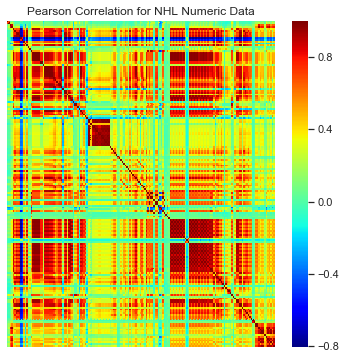

In [69]:
#Visualize the correlation using the Seaborn Heatmap
plt.figure(figsize=(6,6))
sns.heatmap(nhl_numeric_corr,xticklabels=False,yticklabels=False,cmap='jet')
plt.title('Pearson Correlation for NHL Numeric Data')
plt.show()

In [70]:
nhl_numeric_corr

,PlInf_Ht,PlInf_Wt,PlInf_Age,PlInf_Seasons,PrimStat_GP,PrimStat_G,PrimStat_A,PrimStat_A1,PrimStat_PTS,PrimStat_Rnk,...,CarStat_G.1,CarStat_A.1,CarStat_PTS.1,CarStat_+/-.1,CarStat_PIM.1,CarStat_Shot,CarStat_TOI.4,CarStat_OPS.1,CarStat_DPS.1,CarStat_PS.1
PlInf_Ht,1.000000,0.710346,0.021504,0.094140,0.035334,-0.057009,-0.026395,-0.035386,-0.040914,0.075252,...,0.031226,0.063260,0.051999,0.037739,0.194832,0.071871,0.120967,0.040747,0.154807,0.094208
PlInf_Wt,0.710346,1.000000,0.187930,0.251291,0.123589,-0.022018,0.002727,-0.008092,-0.007496,-0.010954,...,0.137994,0.148756,0.148494,0.013914,0.325507,0.198691,0.235222,0.122856,0.231495,0.184050
PlInf_Age,0.021504,0.187930,1.000000,0.880672,0.210546,0.034032,0.103064,0.097473,0.080542,-0.164133,...,0.602606,0.664129,0.657489,0.269247,0.683459,0.700226,0.778026,0.543479,0.662463,0.660643
PlInf_Seasons,0.094140,0.251291,0.880672,1.000000,0.343502,0.204021,0.279076,0.266434,0.265085,-0.301750,...,0.742150,0.804430,0.801358,0.283771,0.779338,0.847190,0.916598,0.685974,0.767722,0.804685
PrimStat_GP,0.035334,0.123589,0.210546,0.343502,1.000000,0.649192,0.710593,0.674445,0.729456,-0.808465,...,0.363637,0.393513,0.392250,0.127485,0.299017,0.414356,0.448730,0.345471,0.369611,0.398020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CarStat_Shot,0.071871,0.198691,0.700226,0.847190,0.414356,0.458984,0.481853,0.477771,0.502528,-0.442003,...,0.948882,0.923424,0.959268,0.380048,0.704500,1.000000,0.895682,0.925267,0.692154,0.939233
CarStat_TOI.4,0.120967,0.235222,0.778026,0.916598,0.448730,0.303125,0.442256,0.408746,0.411603,-0.397739,...,0.761577,0.886462,0.860233,0.370157,0.757407,0.895682,1.000000,0.764694,0.905926,0.918372
CarStat_OPS.1,0.040747,0.122856,0.543479,0.685974,0.345471,0.520963,0.549491,0.542940,0.572039,-0.431701,...,0.957028,0.939932,0.972837,0.469947,0.569996,0.925267,0.764694,1.000000,0.562276,0.935989
CarStat_DPS.1,0.154807,0.231495,0.662463,0.767722,0.369611,0.136382,0.356119,0.295886,0.286193,-0.289478,...,0.496427,0.716586,0.646975,0.470922,0.653232,0.692154,0.905926,0.562276,1.000000,0.817391


In [71]:
#Melt our correlation data frame to better sort and compare our given feature columns
nhl_corr_table = nhl_numeric_corr.abs().reset_index().melt(id_vars='index',var_name='col_corr',value_name='corr_value').copy()

#Take subset where index is not the same as column compared to, since this has a correlation of 1 by definition
#Drop correlation values below .4 for being to weak
nhl_corr_table = nhl_corr_table[(nhl_corr_table.corr_value <=.9999) & (nhl_corr_table.corr_value >= .4)]

In [72]:
nhl_corr_table.sort_values(by='corr_value',ascending=False).head()

,index,col_corr,corr_value
21071,OITStat_GF.1,OITStat_GF,0.999882
23029,OITStat_GF,OITStat_GF.1,0.999882
23209,OITStat_GA,OITStat_GA.1,0.999800
21251,OITStat_GA.1,OITStat_GA,0.999800
3961,PrimStat_TOI%,PrimStat_TOI/GP,0.999596


### Due to the amount of features we still have many pairs after selecting only the medium to strongly correlated columns. The other thing to note is many of our strong correlations with values over .9 come from comparing features from the same data, but from a different reporting agent. As an example, OITStat_GF and OITStat_GF.1 both come from the teams goals when a given player is on the ice, but one is reported from the NHL and the other from a fan site.

### For a clear view and in an effort to reduce confusion we will go back to working with our first_look_df, and view the correlation factors within that data. From this we may also be able to build insightful figures using scatter plots to visualize how different features effect the salary of a player.

In [73]:
#Compute the correlation values on first_look_df
first_look_corr = first_look_df.corr(method='pearson')

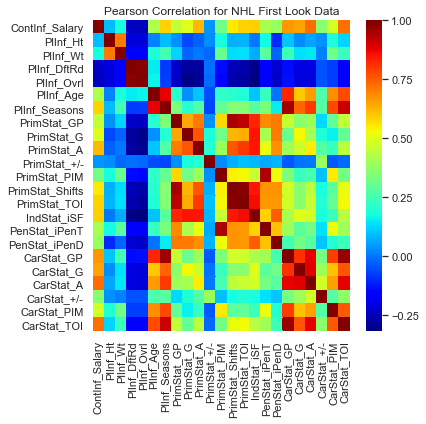

In [74]:
#Visualize the correlation using the Seaborn Heatmap
plt.figure(figsize=(6,6))
sns.heatmap(first_look_corr,xticklabels=first_look_corr.columns,yticklabels=first_look_corr.columns,cmap='jet')
plt.title('Pearson Correlation for NHL First Look Data')
plt.tight_layout()
plt.show()

In [75]:
#Order salary correlation by least to greatest
first_look_corr['ContInf_Salary'].sort_values(ascending=False)

ContInf_Salary     1.000000
CarStat_A          0.729991
CarStat_TOI        0.722220
CarStat_GP         0.665707
CarStat_G          0.653386
PrimStat_A         0.623879
IndStat_iSF        0.592681
PrimStat_TOI       0.586055
PlInf_Seasons      0.583421
PrimStat_Shifts    0.553661
PrimStat_G         0.498103
CarStat_PIM        0.476228
PrimStat_GP        0.453758
PlInf_Age          0.421092
PenStat_iPenT      0.409835
PenStat_iPenD      0.382759
CarStat_+/-        0.358865
PrimStat_PIM       0.323496
PlInf_Wt           0.181149
PlInf_Ht           0.093888
PrimStat_+/-       0.039553
PlInf_DftRd       -0.236688
PlInf_Ovrl        -0.247988
Name: ContInf_Salary, dtype: float64

### This view is much more manageable. As expected a player's salary correlates highly with stats such as goals, assists, and time on ice. Interestingly from this data it does not correlate well with draft round, or overall draft position. We can see that the current season +/- does not affect salary, but career wide +/- does. Interestingly height and weight seem to have no correlation to how much a player will earn at all.

### We notice other links such as high goals and assists obviously contribute to high +/-, so the large area of red in the bottom right comes from the relation to how +/- is calculated. Time played stats such as time spent on ice and shifts played also correlate strongly to many goal/point associated features.

In [76]:
abrev_bokeh_dict_1 = {'ContInf_Salary':['Salary','Dollars ($)'],'PlInf_Ht':['Height','Inches'],'PlInf_Wt':['Weight','Lbs.'],
                   'PlInf_Age':['Age','Years'],'PlInf_Seasons':['Seasons Played','Number'],'PrimStat_GP':['Games Played','Number'],
                    'PrimStat_G':['Goals Scored','Number'],'PrimStat_A':['Assists Made','Number'],
                    'PrimStat_+/-':['Plus-Minus','Number'],'PrimStat_PIM':['Penalties in Minutes','Minutes'],
                    'PrimStat_Shifts':['Shifts Played','Number'],'PrimStat_TOI':['Time On Ice','Seconds'],
                    'IndStat_iSF':['Shots on Goal','Number'],'PenStat_iPenT':['Penalties Taken','Number'],
                    'PenStat_iPenD':['Penalties Drawn','Number'],'CarStat_GP':['Career Total Games Played','Number'],
                   'CarStat_G':['Career Total Goals','Number'],'CarStat_A':['Career Total Assists','Number'],
                    'CarStat_+/-':['Career Total Plus-Minus','Number'],'CarStat_PIM':['Career Total Penalties in Minutes','Number'],
                    'CarStat_TOI':['Career Total Time on Ice','Minutes']}

In [77]:
p=figure()
#Import CategoricalColorMapper from bokeh.models
from bokeh.models import CategoricalColorMapper
from bokeh.palettes import viridis
from bokeh.models import HoverTool

sal_max = first_look_df['ContInf_Salary'].max()

# Convert df to a ColumnDataSource: source
source = ColumnDataSource(data={
        'x'       : first_look_df['PrimStat_G'],
        'y'       : first_look_df['PrimStat_Shifts'],
        'salary'      : (first_look_df['ContInf_Salary']/sal_max)*25,
        'country'      : first_look_df['PlInf_Nat'],
        'player_name'      : first_look_df['PlInf_Name'],
    })

# Make a color mapper: color_mapper
color_mapper = CategoricalColorMapper(factors=first_look_df['PlInf_Nat'].unique().tolist(),palette=viridis(18))

# Add a circle glyph to the figure p
p.circle('x', 'y', source=source,color=dict(field='country', transform=color_mapper),legend='country',size='salary')

# Set the x-axis label
p.xaxis.axis_label =abrev_bokeh_dict_1['PrimStat_G'][0]
    
# Set the y-axis label
p.yaxis.axis_label = abrev_bokeh_dict_1['PrimStat_Shifts'][0]

# Create a HoverTool object: hover
hover = HoverTool(tooltips=[('Name','@player_name')])

# Add the HoverTool object to figure p
p.add_tools(hover)

# Specify the name of the output file and show the result
show(p)

In [78]:
#This function will push the bokeh plot with updateds
def modify_doc(doc):
    
    #Create figure
    p2=figure(plot_height=600,plot_width=700)
    
    #define dictionary for drop down menu purposes
    abrev_bokeh_dict_1 = {'PlInf_Ht':['Height','Inches'],'PlInf_Wt':['Weight','Lbs.'],
                   'PlInf_Age':['Age','Years'],'PlInf_Seasons':['Seasons Played','Number'],'PrimStat_GP':['Games Played','Number'],
                    'PrimStat_G':['Goals Scored','Number'],'PrimStat_A':['Assists Made','Number'],
                    'PrimStat_+/-':['Plus-Minus','Number'],'PrimStat_PIM':['Penalties in Minutes','Minutes'],
                    'PrimStat_Shifts':['Shifts Played','Number'],'PrimStat_TOI':['Time On Ice','Seconds'],
                    'IndStat_iSF':['Shots on Goal','Number'],'PenStat_iPenT':['Penalties Taken','Number'],
                    'PenStat_iPenD':['Penalties Drawn','Number'],'CarStat_GP':['Career Total Games Played','Number'],
                   'CarStat_G':['Career Total Goals','Number'],'CarStat_A':['Career Total Assists','Number'],
                    'CarStat_+/-':['Career Total Plus-Minus','Number'],'CarStat_PIM':['Career Total Penalties in Minutes','Number'],
                    'CarStat_TOI':['Career Total Time on Ice','Minutes']}
    # Make the ColumnDataSource for main graph: source
    
    #Scale factor to visualize salary
    sal_max = first_look_df['ContInf_Salary'].max()

    # Convert df to a ColumnDataSource: source
    source = ColumnDataSource(data={
            'x'       : first_look_df['PrimStat_G'],
            'y'       : first_look_df['PrimStat_Shifts'],
            'salary'      : (first_look_df['ContInf_Salary']/sal_max)*25,
            'country'      : first_look_df['PlInf_Nat'],
            'player_name'      : first_look_df['PlInf_Name'],
        })
    
    ####################################
    #Make the widgets that will go into our interactive graph
         
    #It will be slightly confusing, but for user's ease we will flip flop our dictionary so that the drop down
    #menu makes better sense of our options to choose from
    non_abrev = [item[0] for item in abrev_bokeh_dict_1.values() ]
    is_abrev = [item for item in abrev_bokeh_dict_1.keys()]
    
    #Creat the second dictionary where we have reversed our key value pair. The reasoning will be so that a 
    #user can make sense of our drop down menu, then Bokeh will update the value from mapping to the dictionary. This
    #Value is a column of our dataframe. Finally, when updating we use the reverse mapping to call values from the dataframe
    #column name to get the plot label and axes label
    abrev_bokeh_dict_2 = dict(zip(non_abrev,is_abrev))
    
    
    #These lines define the x and y axis drop down choices
    x_select = Select(
        options=non_abrev,
        value='Shifts Played',
        title='X-Axis Stat'
    )
    
    y_select = Select(
        options=non_abrev,
        value='Goals Scored',
        title='Y-Axis Stat'
    )
    
    
    
    
    #######################################
    #We now must define callback functions for our varius widgets
    
    # Define the callback function: update_plot
    def update_plot(attr, old, new):
        
        #Get new values from drop down values
        x = abrev_bokeh_dict_2[x_select.value]
        y = abrev_bokeh_dict_2[y_select.value]
        
        
        # Read the current value off the slider and dropdown: x and y. Update source data using dictionary, NOT ColumnSourceData
        new_data = {
            'x'       : first_look_df[x],
            'y'       : first_look_df[y],
            'salary'      : (first_look_df['ContInf_Salary']/sal_max)*15+5,
            'country'      : first_look_df['PlInf_Nat'],
            'player_name'      : first_look_df['PlInf_Name'],
        }
        # Assign new_data to source.data
        
        # Set the x-axis label
        p2.xaxis.axis_label =abrev_bokeh_dict_1[x][0]+' ('+abrev_bokeh_dict_1[x][1]+')'

        # Set the y-axis label
        p2.yaxis.axis_label = abrev_bokeh_dict_1[y][0]+' ('+abrev_bokeh_dict_1[y][1]+')'
        
        source.data = new_data
        
    
        
        
    
    ####################################################
    #We must now call all of our change values incase one of the widget value changes,
    #here we can update both the graph and axes so that whenever any widget changes our
    #plot updates
    
    # Attach the update_plot callback to the 'value' property of y_select
    y_select.on_change('value',update_plot)
    
    # Attach the update_plot callback to the 'value' property of agg_select
    x_select.on_change('value',update_plot)
    
    
    # Make a color mapper: color_mapper
    color_mapper = CategoricalColorMapper(factors=first_look_df['PlInf_Nat'].unique().tolist(),palette=viridis(18))

    # Add a circle glyph to the figure p
    p2.circle('x', 'y', source=source,color=dict(field='country', transform=color_mapper),legend='country',size='salary')
    
    # Set the x-axis label
    p2.xaxis.axis_label =abrev_bokeh_dict_1['PrimStat_G'][0]+' ('+abrev_bokeh_dict_1['PrimStat_G'][1]+')'

    # Set the y-axis label
    p2.yaxis.axis_label = abrev_bokeh_dict_1['PrimStat_Shifts'][0]+' ('+abrev_bokeh_dict_1['PrimStat_Shifts'][1]+')'
    
    #Create a title
    p2.title.text = 'NHL 2017-2018 Stat Correlation'
    
    # Set Label sizes
    p2.title.text_font_size = '15pt'
    
    p2.yaxis.major_label_text_font_size = '11pt'
    p2.xaxis.major_label_text_font_size = '11pt'

    p2.xaxis.axis_label_text_font_size = '12pt'
    p2.yaxis.axis_label_text_font_size = '12pt'

    # Create a HoverTool object: hover
    hover = HoverTool(tooltips=[('Name','@player_name')])

    # Add the HoverTool object to figure p
    p2.add_tools(hover)
    
    ####################
    #Set the layout for the plot so it is visually pleasing.
    layout = column(row(widgetbox(x_select,y_select),p2))
    
    #This current work around sets the legend outside of the figure
    new_legend = p2.legend[0]
    p2.add_layout(new_legend,'right')
    
    #Customize legend border
    p2.legend.border_line_width = 3
    p2.legend.border_line_color = "black"
    p2.legend.border_line_alpha = 0.5
    
    #Customize plot border
    p2.outline_line_width = 3
    p2.outline_line_color = "black"
    p2.outline_line_alpha = 0.5
    
    #Set the doc and then show the modified document, having an interactive graph
    doc.add_root(layout)
show(modify_doc)

### This concludes the data cleaning and EDA process. If you are interested in seeing how it was used to create a predictive model for NHL player salaries you may find that work in the Jupyter Notebook 'NHL 2017-2018 Salary Linear Regression Model'. Thank you, and feel free to send feedback to willdupree90@gmail.com. Also a big thank you to Hockey Abstract for making this data available.